In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('../bioAI.mplstyle')
import expipe
import pathlib
import numpy as np
import numpy.ma as ma
import scipy
import tqdm
import pandas as pd

from scipy.interpolate import interp1d
import sys
sys.path.append('..')
import ca2_mec.project_path
import expipe_plugin_cinpla
from expipe_plugin_cinpla.tools.trackunitmulticomparison import TrackMultipleSessions
import expipe_plugin_cinpla.tools.data_processing as dp
from expipe_plugin_cinpla.tools.registration import store_notebook
import spatial_maps as sp
#from ca2_mec.utils import *
from ca2_mec.plotting_functions import spike_track

In [25]:
speed_filter = 5 # m/s
pos_fs = 100 
f_cut = 6
box_xlen = 1 
box_ylen = 1 
binsize =  0.02
smoothing = 0.03

position_sampling_rate = 100 # for interpolation
position_low_pass_frequency = 6 # for low pass filtering of position

box_size = [box_xlen, box_ylen]

In [26]:
project_path = ca2_mec.project_path.project_path()

project = expipe.get_project(project_path)
actions = project.actions

/fp/projects01/ec109/software/expipe/expipe/core.py:700: UserWarning: Requested project with name 'hpc-social-nwb', but found 'hpc-social'
  warnings.warn(


In [27]:
data_loader = dp.Data(project,
    position_sampling_rate=position_sampling_rate, 
    position_low_pass_frequency=position_low_pass_frequency,
    box_size=box_size, bin_size=binsize, 
    stim_mask=False, baseline_duration=None
)

In [28]:
#lim = [0,1200] # limit recording times - in seconds
include_actions = ['001-181220-2']
#include_actions = ['011-120321-2', '011-120321-3', '011-120321-4', '011-120321-5', '011-120321-6'] # choose actions to include
#include_actions = ['022-160322-1', '022-160322-2', '022-160322-3', '022-160322-4', '022-160322-5', '022-160322-7']

# Cast assertion error if include_actions contain actions from multiple entities. 
animal_entity = include_actions[0].split('-')[0]
multiple_entities = all([animal_entity in action_id for action_id in include_actions])
assert multiple_entities, "Requires only actions from same animal entity! Read start of notebook!"
spatial_map = sp.SpatialMap()

In [40]:
def unit_summary(x,y,t,spike_train,action_id,**kwargs):
    fig,axs = plt.subplots(nrows=2,ncols=4,**kwargs)
    
    # ratemap
    ratemap = spatial_map.rate_map(x,y,t,spike_train)
    axs[0,0].imshow(ratemap.T,origin='lower')
    axs[0,0].set_title(
        f'grp={spike_train.annotations["group"]}, unit={spike_train.annotations["name"]}'
    )
    
    # spikes and tracking
    axs[0,1] = spike_track(x,y,t,spike_train,axs[0,1],spines=False)
    axs[0,1].axis('equal')
    axs[0,1].set_title(f'#spikes={spike_train.shape[0]}')
    
    # occupancy
    occupancymap = spatial_map.occupancy_map(x,y,t)
    axs[0,2].imshow(occupancymap.T,origin='lower')
    axs[0,2].set_title('occupancy')
    
    axs[0,3].set_title(f'{action_id}')
    
    mean_wfs = spike_train.annotations['waveform_mean']
    min_max = np.min(mean_wfs), np.max(mean_wfs)
    for i in range(mean_wfs.shape[1]): #if 4 channels in every tetrode: range(4)
        axs[1,i].plot(mean_wfs[:,i])
        axs[1,i].set_ylim(*min_max)
        #axis_off_labels_on(axs[0,i])
    axs[1,0].set_ylabel('Mean waveform')
    
    return fig, axs

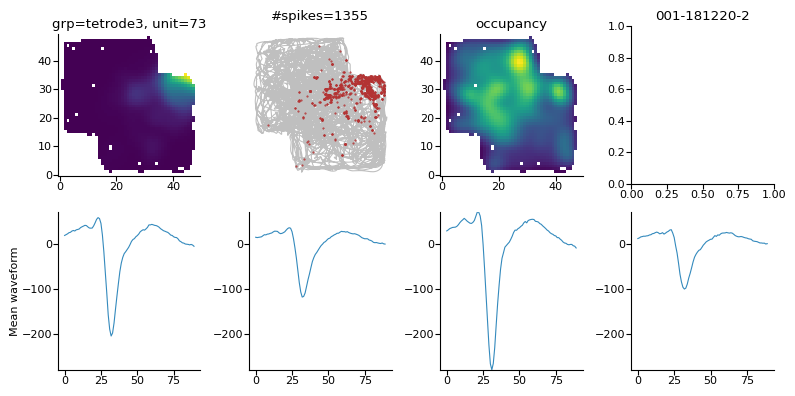

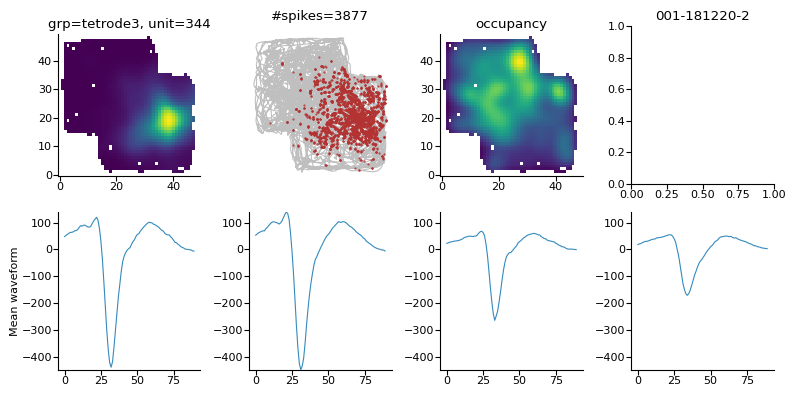

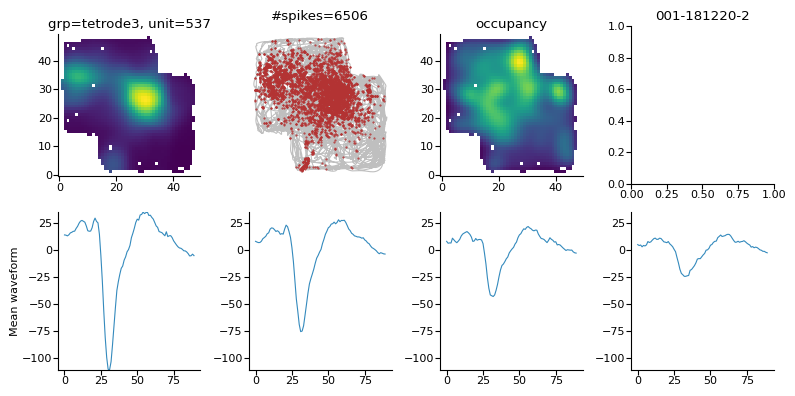

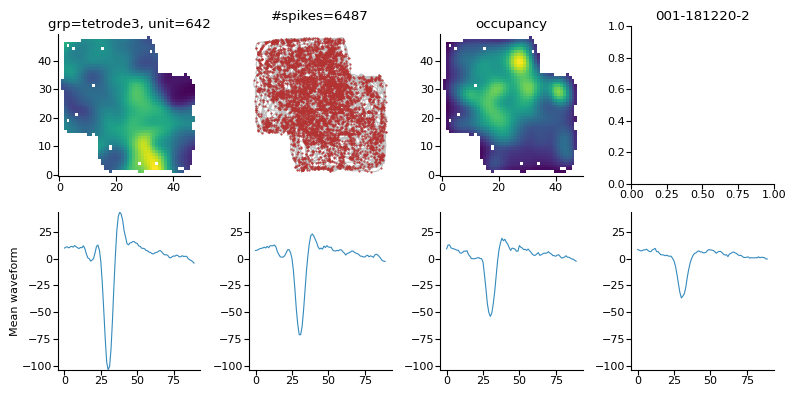

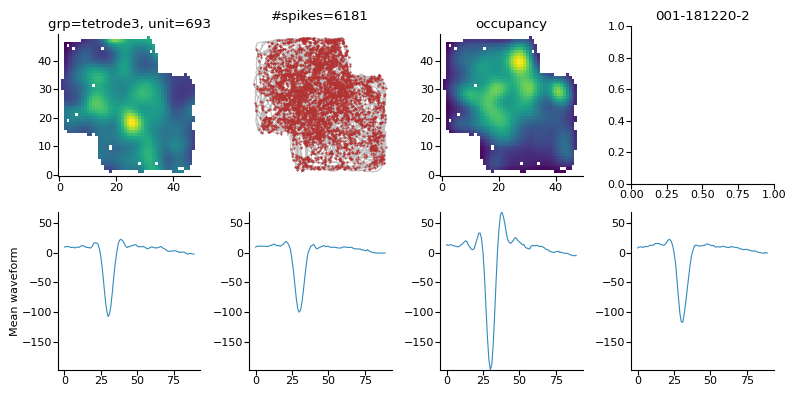

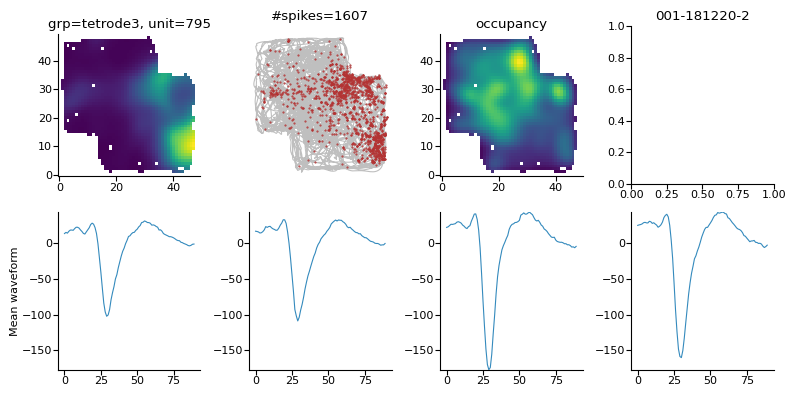

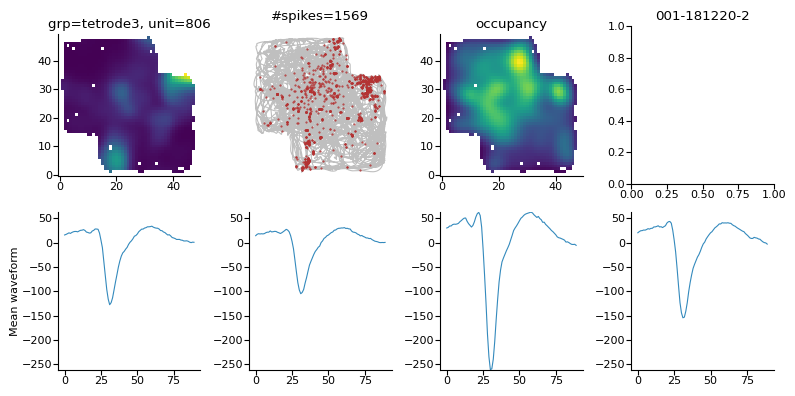

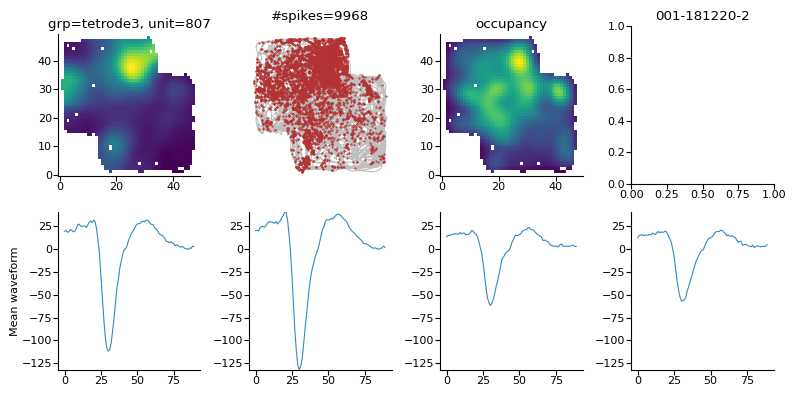

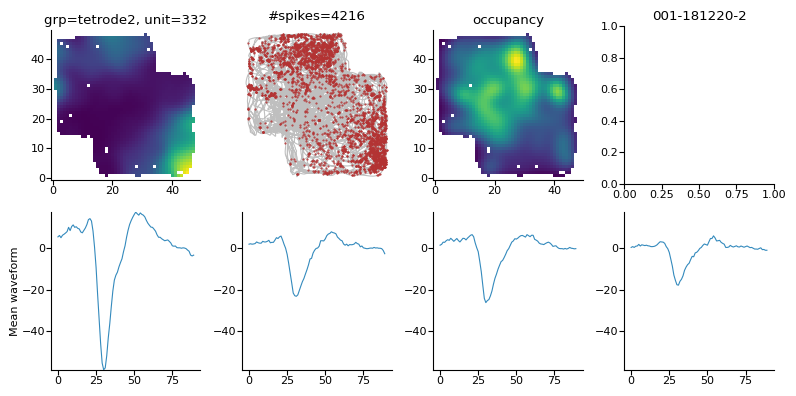

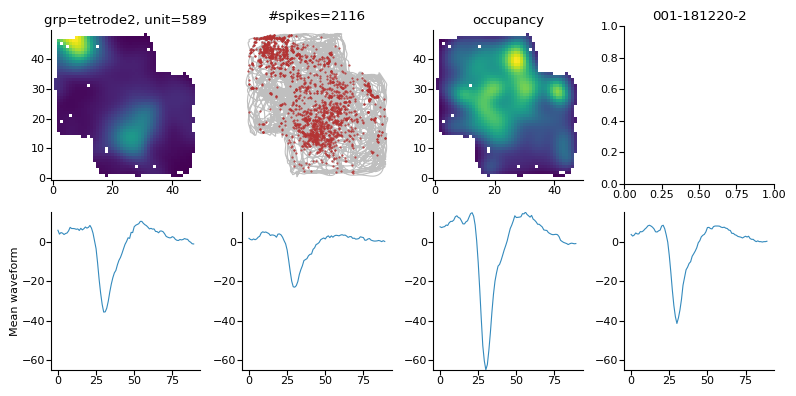

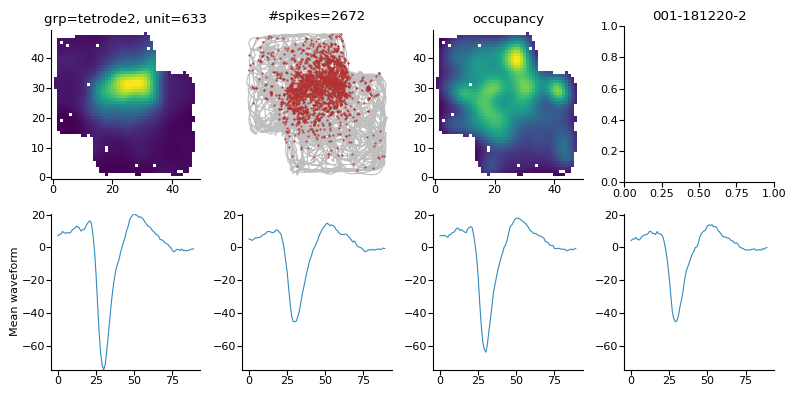

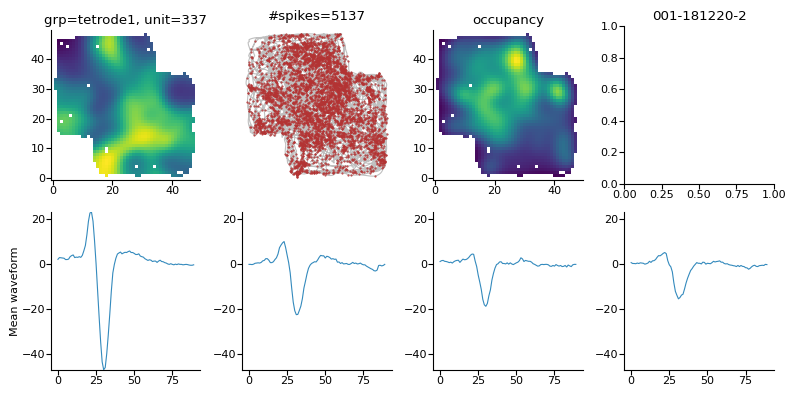

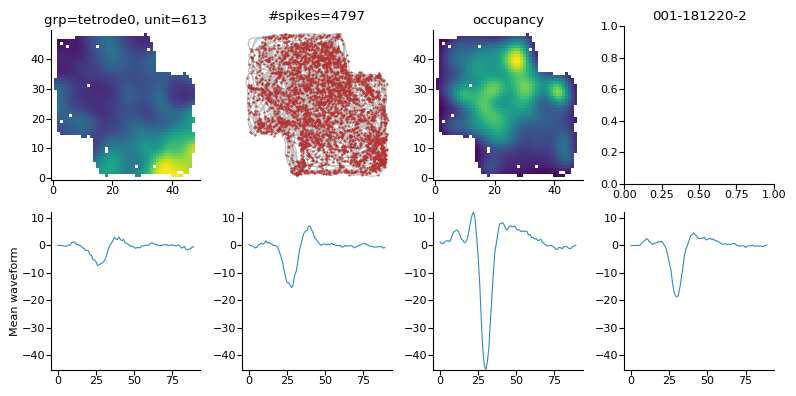

In [41]:
figsize=(8,4)

for action_id in include_actions:
    x, y, t, speed = map(data_loader.tracking(action_id).get, ['x', 'y', 't', 'v'])
    x, y = x, 1 - y
    for chgrp, spike_trains in data_loader.spike_trains(action_id).items():
        for unit_id, spike_train in spike_trains.items():
            fig,axs=unit_summary(x,y,t,spike_train,action_id,figsize=figsize)

In [37]:
spike_train.annotations['waveform_mean'].shape

(90, 4)